In [2]:
# Install dependencies

!python3 -m pip install --upgrade pip > /dev/null
!pip install numpy pandas seaborn > /dev/null
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import requests
from pathlib import Path

sns.set_theme(style="white")

In [3]:
# Download data

def _download_data(url, path):
  path = Path(path)
  path.parent.mkdir(parents=True, exist_ok=True)
  if not path.is_file():
    print(f"{path} not found, downloading")
    with open(path, "wb") as file:
      file.write(requests.get(url, allow_redirects=True).content)
  else:
    print(f"{path} on instance, skipping download")

navn_url = "https://raw.githubusercontent.com/martgra/fagmote_syntetiske_data/master/data/navn.txt"
navn_path = "data/navn.txt"
_download_data(navn_url, navn_path)

cardio_train_url = "https://raw.githubusercontent.com/martgra/fagmote_syntetiske_data/master/data/cardio_train.csv"
cardio_train_path = "data/cardio_train.csv"
_download_data(cardio_train_url, cardio_train_path)


data/navn.txt on instance, skipping download
data/cardio_train.csv on instance, skipping download


# Sampling from known distributions
We assume that height, weight and income follows a normal distribution. 

In the following example we assume that:

#### Distribution
* The mean hight of the population is **180 cm** and the standard deviation is **15 cm**. (Male and female combined)
* The mean weight of the population is **80 kg** and the standard deviation is **12 kg**. (Male and female combined)
* The mean income is **650000 NOK** and the standard deviation is **50000**.  

#### Correlation
* The correlation between height and weight is **0.8**
* The correlation between **income** and **height** is **0.3**
* The correlation between **income** and **weight** is **-0.2** 

#### _Feel free to tweek these parameters_

_Resources:_  
https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html  
https://towardsdatascience.com/multivariate-normal-distribution-562b28ec0fe0


In [4]:
# Define statistical properties of population
mean_height = 170
sd_height = 15

mean_weight = 80
sd_weight = 12

mean_income = 650000
sd_income=50000

std_matrix = np.array([
    [sd_height, 0, 0],
    [0, sd_weight, 0],
    [0,0, sd_income]
])


# Specify desired correlation between variables
corr_height_weight = 0.8
corr_height_income = 0.3
corr_weight_income = -0.2

# Creating covariance matrix to calculate covariance between distributions.
correlation_matrix = np.array([
    [1.0, corr_height_weight, corr_height_income],
    [corr_height_weight, 1.0, corr_weight_income],
    [corr_height_income, corr_weight_income , 1.0]
])
covariance_matrix = np.dot(std_matrix, np.dot(correlation_matrix, std_matrix))


# Sampling from multivariate_distribtuion
num_samples = 10000
samples = np.random.default_rng().multivariate_normal((mean_height, mean_weight, mean_income), covariance_matrix, num_samples)

# Adding samples to Pandas DataFrame
samples_df=pd.DataFrame(samples, columns=["Height", "Weight", "Income"])


### Lets have a look at the data

In [5]:
samples_df.corr()

,Height,Weight,Income
Height,1.000000,0.799504,0.302238
Weight,0.799504,1.000000,-0.195885
Income,0.302238,-0.195885,1.000000


In [6]:
# looking at standard deviations.

print(f"Percentage of people taller than 160 cm: {samples_df[samples_df['Height'] > 160]['Height'].count()/num_samples*100}")
print(f"Percentage of people shorter than 200 cm: {samples_df[samples_df['Height'] < 200]['Height'].count()/num_samples*100}")
print(f"Percentage of people earning more than than 750.000 NOK: {samples_df[samples_df['Income'] > 750000]['Income'].count()/num_samples*100}")

Percentage of people taller than 160 cm: 74.83999999999999
Percentage of people shorter than 200 cm: 97.72
Percentage of people earning more than than 750.000 NOK: 2.12


In [7]:
# Print actual descirptive
samples_df.describe()

,Height,Weight,Income
count,10000.000000,10000.000000,10000.000000
mean,170.081603,80.181265,649359.741247
std,14.960227,11.901507,49427.617015
min,114.660155,32.345764,476947.233498
25%,159.925508,71.965429,615750.372139
50%,170.061376,80.344546,649700.217354
75%,180.226310,88.325462,682692.874709
max,223.463360,131.399266,827404.699502


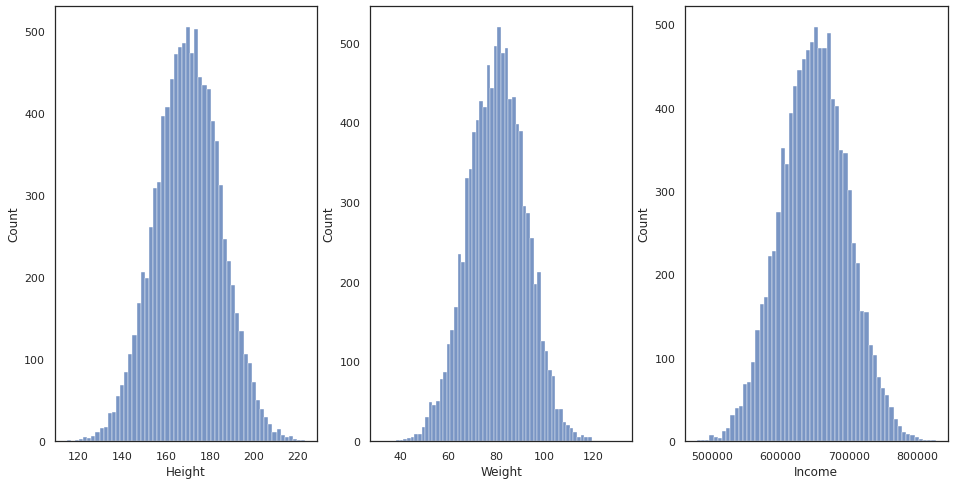

In [8]:
fig, ax =plt.subplots(1,3, figsize=(16,8))
sns.histplot(samples_df['Height'], ax=ax[0])
sns.histplot(samples_df['Weight'], ax=ax[1])
sns.histplot(samples_df['Income'], ax=ax[2])
fig.show()


### We look at the relationship between height and length

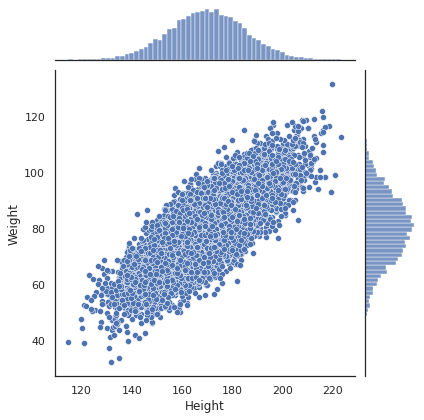

In [9]:
sns.jointplot(data=samples_df, x="Height", y="Weight", ax=ax[0])

In [10]:
# Tallest person
print(samples_df.iloc[samples_df["Height"].idxmax()])


Height       223.463360
Weight       112.422941
Income    709362.002832
Name: 3408, dtype: float64


In [11]:
# Shortest person
print(samples_df.iloc[samples_df["Height"].idxmin()])

Height       114.660155
Weight        39.728705
Income    626756.206271
Name: 8685, dtype: float64


### Adding deterministic relationships

Instead of "sampling" or predicting field with deterministic to other other fields we calculate and add them!
For example BMI

In [12]:
def calculate_bmi(x):
    return x["Weight"] / (x["Height"]/100)**2

samples_df["BMI"]=samples_df.apply(calculate_bmi,axis=1)

samples_df

,Height,Weight,Income,BMI
0,179.931605,93.408475,625313.079784,28.851698
1,162.649850,66.552781,683396.324223,25.157001
2,177.943397,86.459925,620556.551096,27.305561
3,163.693689,78.849846,639925.534710,29.426389
4,170.432083,84.873113,673064.639217,29.219140
...,...,...,...,...
9995,138.171963,63.274070,612174.746607,33.142549
9996,154.367925,76.748889,614237.592658,32.207570
9997,170.120107,87.535918,632428.305744,30.246491
9998,190.232491,96.290219,651451.921259,26.608034


# Utilize ML models

Often understanding the relationships in data can be hard to detect. Here is where machine learning shines. An example is sequentially building datasets with machine learning. 

Consider:
1. Sample from $A$ to get $A'$
2. Build a model $F1:E \sim A$
3. Synthesize $E$ as $E' = F1(A')$
4. Build a model $F2:C \sim A + E$
5. Synthesize $C$ as $C' = F2(A', E')$
6. Build a model $F3:B \sim A + E + C$
7. Synthesize $B$ as $B' = F3(A', E' +C')$
8. Build a model $F4:D \sim A + E +C + B$
9. Synthesize $D$ as $D' = F4(A', E', C' B')$

#### OBS: The method requires access to original data that models the relationship.

In this example we use cardio-vascular dataset to model gender from already sampled data. The dataset holds both **height**, **weight** and **gender**. 

_Resources:_  
https://www.kaggle.com/sulianova/cardiovascular-disease-dataset  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html



In [13]:
from sklearn.linear_model import LogisticRegression

# Loading dataset to create gender generator
with open("data/cardio_train.csv") as file:
    data = pd.read_csv(file, delimiter=";")
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [14]:
# Fitting linear regressor to predict gender from height and weight

X = data[["height", "weight"]]
y = data["gender"]
clf = LogisticRegression().fit(X, y)

In [15]:
# Assigning gender based on height and weight

def generate_gender(x):
    categories = ["female", "male"]
    probability = clf.predict_proba([[x["Height"],x["Weight"]]])[0]
    return np.random.choice(categories, 1, p=probability)[0]

samples_df["Gender"]=samples_df.apply(generate_gender,axis=1)


### Lets look at the count of gender in the distribution

/home/vagrant/dev/fagmøte/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Gender', ylabel='count'>

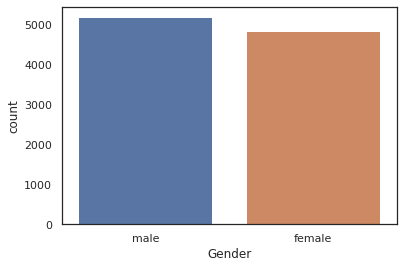

In [16]:
sns.countplot(samples_df['Gender'])

In [17]:
samples_df.head()

,Height,Weight,Income,BMI,Gender
0,179.931605,93.408475,625313.079784,28.851698,male
1,162.649850,66.552781,683396.324223,25.157001,female
2,177.943397,86.459925,620556.551096,27.305561,male
3,163.693689,78.849846,639925.534710,29.426389,female
4,170.432083,84.873113,673064.639217,29.219140,male


# Enter deep neural networks

When relationships are complicated we can utilize generative techniques from neural netowrks.  Examples of generative techniques are:

* **DCGAN** to generate faces: https://keras.io/examples/generative/dcgan_overriding_train_step/
* **Autoencoders**: https://www.tensorflow.org/tutorials/generative/autoencoder
* **RNN** to generate Shakespear: http://karpathy.github.io/2015/05/21/rnn-effectiveness/ 


In this example we utilize the technique desciribed in Andrej Karpathys blogpost "The Unreasonable Effectiveness of Recurrent Neural Networks". The post is refined here: 

* https://www.tensorflow.org/tutorials/text/text_generation

## The rational
We want to couple a reasonable name to each sample in our population. Let's train a neural network to create plausible names based on gender. 

To accomplish this we have scraped the 1000 most common names for men and the 1000 most common names for women in Norway. The names are denoted with a special characted in front to indicate if the name is **male** (-) or **female** (*)

In [18]:
# Ensure that tensorflow is installed
!pip install tensorflow > /dev/null 

# Import nessesary libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

In [19]:
# Load "Name dataset"
with open("data/navn.txt") as file:
    original_names_dataset = file.read()

# Find unique characters in text. Used to encode charactes
vocab = sorted(set(original_names_dataset))

# Create functions to convert chars to ints and from ints to chars
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True)

In [20]:
# Create dataset from loaded text
all_ids = ids_from_chars(tf.strings.unicode_split(original_names_dataset, input_encoding='UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

seq_length = 10
examples_per_epoch = len(original_names_dataset)//(seq_length+1)

# Create "sequences of text" from full text
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

#### Creating input and target examples

Observe that what we predict is the "next characters" shifted one place to the right. The neural networks job is to understand what comes "next" based on the current and previous states. 

Like humans - knowing more context gives a better guess! 

In [21]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text
dataset = sequences.map(split_input_target)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

for input_example, target_example in  dataset.take(1):
    print("Input  :{} --> {}".format(text_from_ids(input_example).numpy(), input_example.numpy()))
    print("Target :{} -->    {}".format(text_from_ids(target_example).numpy(), target_example.numpy()))

Input  :b'*Nora\n*Nor' --> [ 4 23 48 51 34  2  4 23 48 51]
Target :b'Nora\n*Nora' -->    [23 48 51 34  2  4 23 48 51 34]


In [22]:
# Dataset properties.
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 10), (64, 10)), types: (tf.int64, tf.int64)>

In [23]:
# Defining model

class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True, 
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    
    # Optional: Add or remove layers if you want to play with the model architecture. 
    # For example adding a extra layer:
    
    # x, states = self.gru(x, initial_state=states, training=training)
    
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else: 
      return x

In [24]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units. OPTIONAL: Tune this number to play with model!
rnn_units = 256


model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

#### Training the model

The model is trained in the name-dataset. Try tuning either the model architecture (further up in notebook) or number of EPOS to train data.

_TIPS: EPOS is one iteration of the enitire dataset_

In [25]:
# Train the model
EPOS = 30 # Change to specify how many times training should occur over. Longer training MAY result in better predictions.

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)
history = model.fit(dataset, epochs=EPOS)

Epoch 1/30
22/22 [==============================] - 1s 22ms/step - loss: 3.9876
Epoch 2/30
22/22 [==============================] - 1s 20ms/step - loss: 3.0674
Epoch 3/30
22/22 [==============================] - 1s 21ms/step - loss: 2.4954
Epoch 4/30
22/22 [==============================] - 1s 21ms/step - loss: 2.2818
Epoch 5/30
22/22 [==============================] - 1s 21ms/step - loss: 2.1853
Epoch 6/30
22/22 [==============================] - 1s 31ms/step - loss: 2.1265
Epoch 7/30
22/22 [==============================] - 1s 30ms/step - loss: 2.1076
Epoch 8/30
22/22 [==============================] - 1s 24ms/step - loss: 2.0620
Epoch 9/30
22/22 [==============================] - 1s 20ms/step - loss: 2.0196
Epoch 10/30
22/22 [==============================] - 1s 26ms/step - loss: 1.9941
Epoch 11/30
22/22 [==============================] - 1s 23ms/step - loss: 1.9775
Epoch 12/30
22/22 [==============================] - 1s 24ms/step - loss: 1.9472
Epoch 13/30
22/22 [==================

In [26]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, next_char, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits] 
    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

### Generating names

TIPS: Try tweaking **temperature** to alter generation. Highter temperature (closer to 1) gives more creative freedom while lower temperature (closer to 0) gives more conservatie generation. 

In [27]:
# Creating initial state from genders in our sample. 
next_char=list(map(lambda x: "-" if x == "male" else "*",samples_df["Gender"].tolist()))

# Creating the prediction model. OPTIONAL: Tweek temperature to get more conservative or creative generation. 
one_step_model = OneStep(model, chars_from_ids, ids_from_chars, next_char, temperature=0.5)

start = time.time()
states = None
next_char = tf.constant(next_char)
result = [next_char]

# Running prediction on batch with size samples_size with length 15 char 
for n in range(15):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result, '\n\n' + '_'*80)


print(f"\nRun time: {end - start}")

tf.Tensor(
[b'-Mattian\n-Harben' b'*Anne\xe2\x80\x93Karin\n*Ari'
 b'-Jonn\n-Joran\n-Ja' ... b'-Frade\n-Brin\n-No' b'-Friktor\n-Robert'
 b'*Marin\n*Fristine'], shape=(10000,), dtype=string) 

________________________________________________________________________________

Run time: 1.8562581539154053


In [28]:
generated_names = list(result.numpy())
generated_names = list(map(lambda x: x.splitlines()[0].decode("utf-8").replace("*", "").replace("-", ""), generated_names))
samples_df["Names"] = generated_names

### Looking at generated names. 
Observe that some but not all names are found in training data. Try tweaking temperature in the code above to get either more conservative (overlapping) generation or creative (less overlapping) generation. 

In [29]:
names_found_in_original_data = set([population_name for population_name in samples_df["Names"].tolist() if population_name in original_names_dataset] )

print(f"Unique names in generated population: {len(set(samples_df['Names'].tolist()))}")
print(f"Unique names in training population: {len(set(original_names_dataset.splitlines()))}")
print(f"Overlapping names between generated population and training data: {len(names_found_in_original_data)}")


Unique names in generated population: 2624
Unique names in training population: 2004
Overlapping names between generated population and training data: 590


#### Looking at male names

In [30]:
samples_df[samples_df["Gender"]=="male"].head(20)

,Height,Weight,Income,BMI,Gender,Names
0,179.931605,93.408475,625313.079784,28.851698,male,Mattian
2,177.943397,86.459925,620556.551096,27.305561,male,Jonn
4,170.432083,84.873113,673064.639217,29.219140,male,Mahim
5,167.915771,76.789887,685026.134663,27.234603,male,Kans
6,158.727345,72.296347,685520.782769,28.695437,male,Astan
8,200.292402,88.848980,758120.507146,22.147438,male,Michal
10,181.261177,83.615395,680991.762714,25.449348,male,Reiner
12,173.070421,89.152746,673158.018536,29.763844,male,Torman
13,178.776592,75.400376,685457.336365,23.591318,male,Mikolas
16,166.538013,69.414255,695522.459131,25.027756,male,Samun


#### Looking at female names

In [31]:
samples_df[samples_df["Gender"]=="female"].head(20)

,Height,Weight,Income,BMI,Gender,Names
1,162.649850,66.552781,683396.324223,25.157001,female,Anne–Karin
3,163.693689,78.849846,639925.534710,29.426389,female,Lina
7,167.972018,89.256066,556326.452039,31.634710,female,Anne–Gre
9,138.571016,50.423909,708501.682857,26.259818,female,Sanni
11,175.439033,87.448330,624439.141303,28.411821,female,Inger
14,160.397689,74.124625,576593.581503,28.811528,female,Marin
15,148.152912,72.705312,583101.361147,33.124228,female,Jennike
17,156.119085,76.156126,658407.136582,31.245886,female,Elline
19,138.715590,65.595431,533062.612706,34.089689,female,Ingrid
20,157.945047,63.280251,709557.573718,25.366244,female,Karia


## Looking at our dataset

We now take time to look at our dataset.

#### First a correlation plot
Does the relationships between different properties of the dataset make sense? 

<AxesSubplot:>

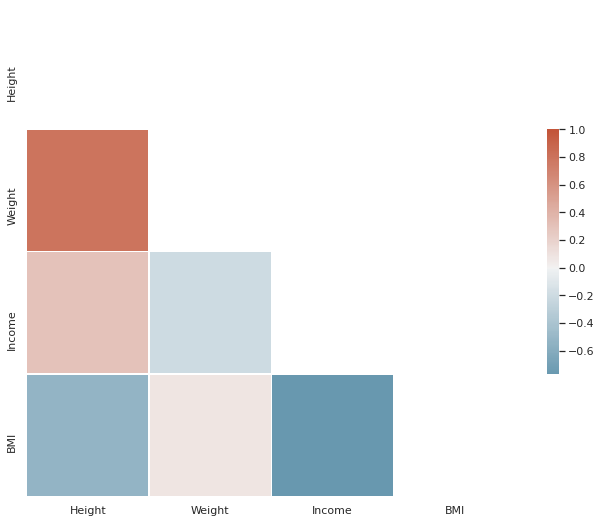

In [32]:
# Compute the correlation matrix
corr = samples_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})